In [32]:
using ITensors, ITensorMPS, PythonPlot

# Reset global variables
global psi = []
global energies = []
global sorted_indices = []
global overlap_matrix = nothing

# Number of states to find
global R = 6  

# Length of the spin chain
global L = 30 

# Create L Spin-1/2 Indices
global sites = siteinds("S=1/2", L)

let
    # Create the Hamiltonian (HI) of the Ising chain at its self-dual critical point from the O'Brien and Fendley paper.
    osI = OpSum()
    for j in 1:(L - 1)
        osI -= "X", j 
        osI -= "Z", j, "Z", j + 1
    end
        # Boundary terms
        osI -= "X", L
        osI -= "Z", L, "Z", 1
        HI = MPO(osI, sites)

    # Create the Hamiltonian (H3) of the three-spin interaction from the O'Brien and Fendley paper.
    os3 = OpSum()
    for j in 1:(L - 2)
        os3 += "X", j, "Z", j + 1, "Z", j + 2
        os3 += "Z", j, "Z", j + 1, "X", j + 2
    end
        # Boundary terms
        os3 += "X", L - 1, "Z", L, "Z", 1
        os3 += "X", L, "Z", 1, "Z", 2
        os3 += "Z", L - 1, "Z", L, "X", 1
        os3 += "Z", L, "Z", 1, "X", 2
        H3 = MPO(os3, sites)

    # Coupling coefficients
        # lambdaI = 1
        # lambda3 = 1

    # TCI Coupling coefficients
        lambdaI = 0.7597
        lambda3 = 0.6503

    # Adding energy offset E0
        # EO = L * (lambdaI^2 + lambda3^2) / lambda3
        # osEO = OpSum()
        #     osEO += EO, "Id", 1
        # E0 = MPO(osEO, sites)

    # Full Hamiltonian from paper
        H = 2 * lambdaI * HI + lambda3 * H3 # + E0

    # Create an initial random matrix product state
        psi0 = random_mps(sites)
    
    # Set the number of sweeps, bond dimensions, and cutoff for the DMRG algorithm
        nsweeps = 20
        maxdim = [10, 33, 66, 133, 200]
        cutoff = 1e-10

    println("Maxdim per sweep: ", maxdim)
    println()
    
    # Run DMRG R times to find R states
    global psi = Vector{MPS}(undef, R)
    global energies = zeros(R)

        # Run DMRG once to find a ground state
        println("DMRG run 1:")
        observer = DMRGObserver(; energy_tol=1e-10) # Observer to monitor convergence
        energies[1], psi[1] = dmrg(H, psi0; nsweeps, maxdim, cutoff, observer=observer)
        println("Final energy for DMRG run 1: $(energies[1])")
        println()

        # Find subsequent states while forcing orthogonality
        for i in 2:R
            println("DMRG run $i:")
            energies[i], psi[i] = dmrg(H, psi[1:(i-1)], psi0; nsweeps, maxdim, cutoff, weight=100, observer=observer)
            println("Final energy for DMRG run $i: $(energies[i])")
            println()
        end

    # Sort and label the states
    global sorted_indices = sortperm(energies)

    println("Energy results from DMRG in ascending order:")
    for (i, idx) in enumerate(sorted_indices)
        println("State $i: $(energies[idx])")
    end
    
    # Analysis overlap between states; Return overlap matrix
    function analyze_overlaps(psi, sorted_indices...,)
        n_total = length(sorted_indices)

        # Create an overlap matrix
        overlap_matrix = zeros(ComplexF64, n_total, n_total)

        # Compute the overlaps
        for (i, idx_i) in enumerate(sorted_indices)
            for (j, idx_j) in enumerate(sorted_indices)
                overlap_matrix[i, j] = inner(psi[idx_i], psi[idx_j])
            end
        end

        # Check normalizations
        println("\nNormalizations:")
        for (i, idx) in enumerate(sorted_indices)
            norm_val = abs(overlap_matrix[i,i])
            println("State $i: ⟨ψ$idx|ψ$idx⟩ = $(round(norm_val, digits=8))")
        end

        # Check Orthogonality
        println("\nInner product between states:")
        for i in 1:n_total
            for j in (i+1):n_total
                overlap_val = abs(overlap_matrix[i,j])
                println("⟨ψ$(sorted_indices[i])|ψ$(sorted_indices[j])⟩ = $overlap_val")
            end
        end
        
        return overlap_matrix
    end

    global overlap_matrix = analyze_overlaps(psi, sorted_indices...,)

    nothing
end

Maxdim per sweep: [10, 33, 66, 133, 200]

DMRG run 1:
After sweep 1 energy=-45.357647479572165  maxlinkdim=4 maxerr=1.36E-15 time=0.016
After sweep 2 energy=-46.040270253473906  maxlinkdim=16 maxerr=7.95E-11 time=0.045
After sweep 3 energy=-46.09519555697869  maxlinkdim=52 maxerr=9.97E-11 time=0.165
After sweep 4 energy=-46.1263539521685  maxlinkdim=126 maxerr=9.99E-11 time=1.378
After sweep 5 energy=-46.14434318174041  maxlinkdim=185 maxerr=9.97E-11 time=3.367
After sweep 6 energy=-46.15127139692237  maxlinkdim=200 maxerr=9.97E-11 time=4.407
After sweep 7 energy=-46.15237369718207  maxlinkdim=199 maxerr=1.02E-10 time=4.110
After sweep 8 energy=-46.15249900583193  maxlinkdim=193 maxerr=9.99E-11 time=4.251
After sweep 9 energy=-46.15250898725412  maxlinkdim=185 maxerr=9.96E-11 time=3.759
After sweep 10 energy=-46.15251014266762  maxlinkdim=198 maxerr=9.99E-11 time=4.017
After sweep 11 energy=-46.15251028480322  maxlinkdim=178 maxerr=9.97E-11 time=3.540
After sweep 12 energy=-46.15251030

Maximum and Minimum Correlations:
State 1: 0.582792, 0.43524
State 2: 0.895441, 0.841006
State 3: 0.563805, 0.458309
State 4: 0.566359, 0.286094
State 6: 0.516655, -0.006815
State 5: 0.509231, 0.01929


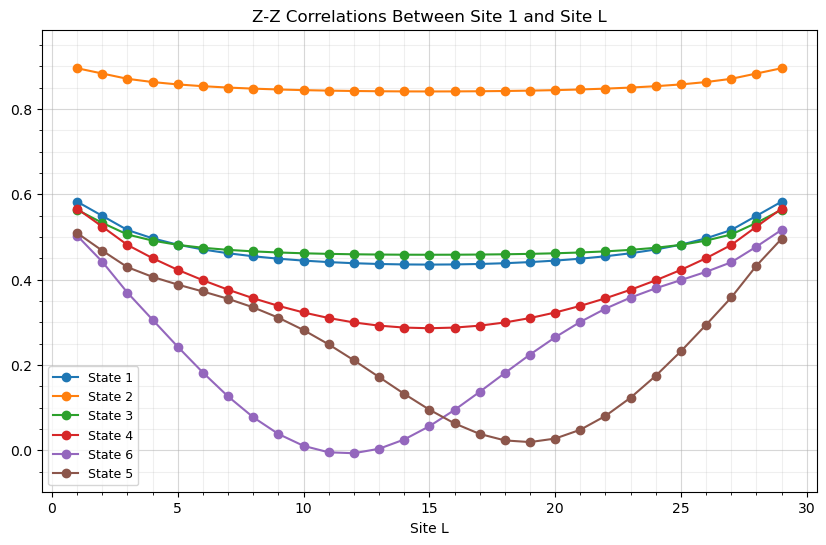

In [33]:
using PythonPlot

# Clear variables
ZZC = Vector{Matrix{ComplexF64}}(undef, R)
# abs_ZZC = Vector{Vector{Float64}}(undef, R)
real_ZZC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute Z-Z correlations matrices for all states
for i in 1:R
    ZZC[i] = correlation_matrix(psi[sorted_indices[i]], "Z", "Z")
end

# Get the absolute values of correlations
# for i in 1:R
#     abs_ZZC[i] = abs.(ZZC[i][1, 2:end])
# end

# Get the real values of correlations
for i in 1:R
    real_ZZC[i] = real.(ZZC[i][1, 2:end])
end

figure(figsize=(10, 6))

# Plot the Z-Z correlations for ground states
for i in 1:R
    x[i] = collect(1:length(real_ZZC[i]))
    plot(x[i], real_ZZC[i], marker="o", linestyle="-", linewidth=1.5,
        label="State $(sorted_indices[i])")
end

legend(fontsize=9)
xlabel("Site L")
title("Z-Z Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()
   
# Adjust graph
ymax = max([maximum(real_ZZC[i]) for i in 1:R]...)
ymin = min([minimum(real_ZZC[i]) for i in 1:R]...)
y_zoom = 0.1 * (ymax - ymin)
ylim(ymin - y_zoom, ymax + y_zoom)

# Print max and min values
println("Maximum and Minimum Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): $(round(maximum(real_ZZC[i]), digits=6)), $(round(minimum(real_ZZC[i]), digits=6))")
end

Maximum and Minimum Correlations:
State 1: 0.549499, 0.43178
State 2: 0.206831, 0.072749
State 3: 0.533118, 0.469832
State 4: 0.536293, 0.352037
State 6: 0.618118, 0.276038
State 5: 0.633755, 0.296441


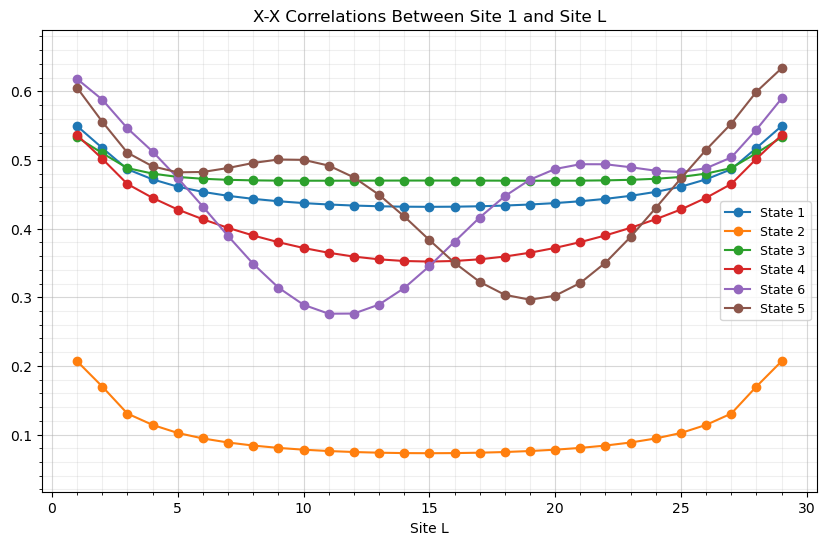

In [34]:
using PythonPlot

# Clear variables
XXC = Vector{Matrix{ComplexF64}}(undef, R)
# abs_XXC = Vector{Vector{Float64}}(undef, R)
real_XXC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute X-X correlations matrices for all states
for i in 1:R
    XXC[i] = correlation_matrix(psi[sorted_indices[i]], "X", "X")
end

# Get the absolute values of correlations
# for i in 1:R
#     abs_XXC[i] = abs.(XXC[i][1, 2:end])
# end

# Get the real values of correlations
for i in 1:R
    real_XXC[i] = real.(XXC[i][1, 2:end])
end

figure(figsize=(10, 6))

# Plot the X-X correlations for ground states
for i in 1:R
    x[i] = collect(1:length(real_XXC[i]))
    plot(x[i], real_XXC[i], marker="o", linestyle="-", linewidth=1.5,
        label="State $(sorted_indices[i])")
end

legend(fontsize=9)
xlabel("Site L")
title("X-X Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()
   
# Adjust graph
ymax = max([maximum(real_XXC[i]) for i in 1:R]...)
ymin = min([minimum(real_XXC[i]) for i in 1:R]...)
y_zoom = 0.1 * (ymax - ymin)
ylim(ymin - y_zoom, ymax + y_zoom)

# Print max and min values
println("Maximum and Minimum Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): $(round(maximum(real_XXC[i]), digits=6)), $(round(minimum(real_XXC[i]), digits=6))")
end

Maximum and Minimum Connected Correlations:
State 1: 0.582792, 0.43524
State 2: 0.895438, 0.841003
State 3: 0.563802, 0.458306
State 4: 0.566359, 0.286094
State 6: 0.516655, -0.006814
State 5: 0.50923, 0.019293


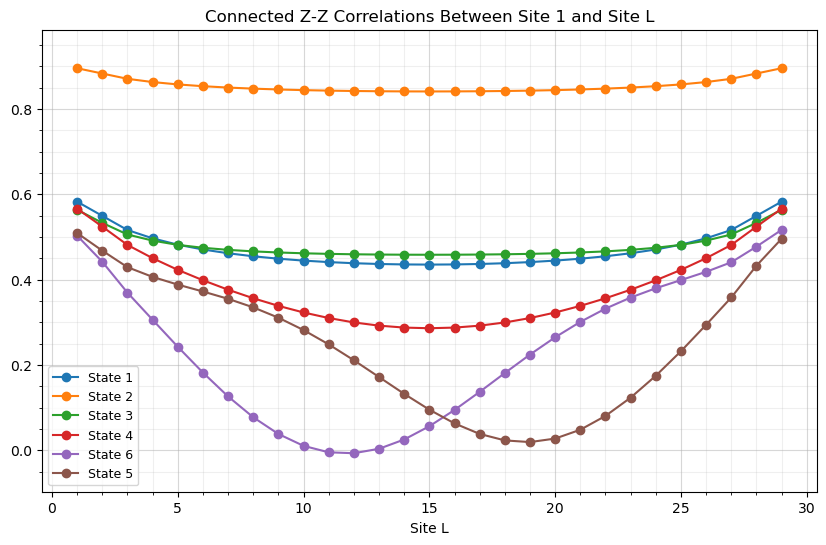

In [35]:
using PythonPlot

# Clear variables
ZZCC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute connected Z-Z correlations for all states
for i in 1:R
    
    # Get the full correlation matrix
    corr_matrix = correlation_matrix(psi[sorted_indices[i]], "Z", "Z")
    
    # Calculate single-site expectations
    Z_exp = Vector{Float64}(undef, L)
    for j in 1:L
        Z_exp[j] = real(expect(psi[sorted_indices[i]], "Z"; sites=j))
    end
    
    # Compute connected correlation: ⟨ψ|Zi Zj|ψ⟩ - ⟨ψ|Zi|ψ⟩ ⟨ψ|Zj|ψ⟩
    ccorrs = Vector{Float64}(undef, L-1)
    for j in 2:L
        RHS = Z_exp[1] * Z_exp[j]
        ccorrs[j-1] = real(corr_matrix[1, j]) - RHS
    end
    
    ZZCC[i] = ccorrs
end

# Plot the connected Z-Z correlations
figure(figsize=(10, 6))

for i in 1:R
    x[i] = collect(1:length(ZZCC[i]))
    plot(x[i], ZZCC[i], marker="o", linestyle="-", linewidth=1.5,
        label="State $(sorted_indices[i])")
end

legend(fontsize=9)
xlabel("Site L")
title("Connected Z-Z Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()

# Adjust graph
ymax = max([maximum(ZZCC[i]) for i in 1:R]...)
ymin = min([minimum(ZZCC[i]) for i in 1:R]...)
y_zoom = 0.1 * (ymax - ymin)
ylim(ymin - y_zoom, ymax + y_zoom)

# Print max and min values
println("Maximum and Minimum Connected Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): $(round(maximum(ZZCC[i]), digits=6)), $(round(minimum(ZZCC[i]), digits=6))")
end

Maximum and Minimum Connected Correlations:
State 1: 0.209853, 0.092134
State 2: 0.139099, 0.005017
State 3: 0.215243, 0.151957
State 4: 0.202251, 0.018083
State 6: 0.190881, -0.101794
State 5: 0.186704, -0.089686


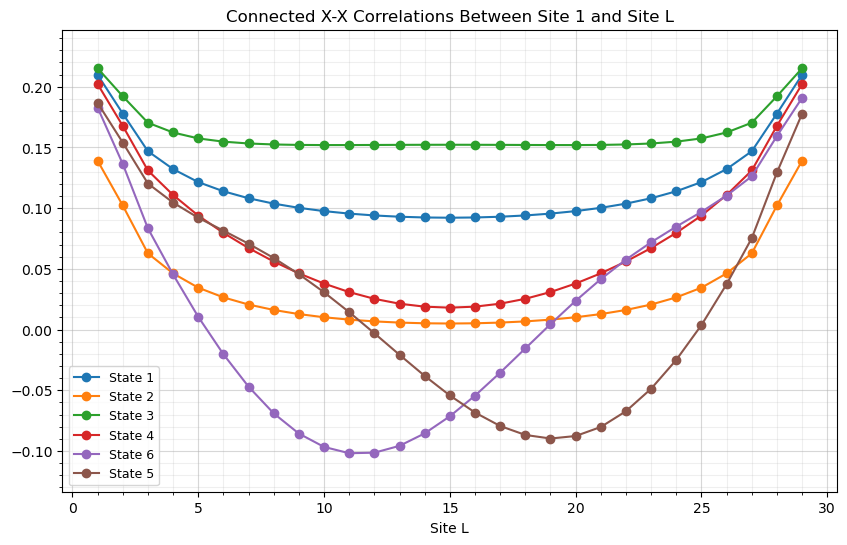

In [36]:
using PythonPlot

# Clear variables
XXCC = Vector{Vector{Float64}}(undef, R)
x = Vector{Vector{Int}}(undef, R)

# Compute connected X-X correlations for all states
for i in 1:R
    
    # Get the full correlation matrix
    corr_matrix = correlation_matrix(psi[sorted_indices[i]], "X", "X")
    
    # Calculate single-site expectations
    X_exp = Vector{Float64}(undef, L)
    for j in 1:L
        X_exp[j] = real(expect(psi[sorted_indices[i]], "X"; sites=j))
    end
    
    # Compute connected correlation: ⟨ψ|Xi Xj|ψ⟩ - ⟨ψ|Xi|ψ⟩ ⟨ψ|Xj|ψ⟩
    ccorrs = Vector{Float64}(undef, L-1)
    for j in 2:L
        RHS = X_exp[1] * X_exp[j]
        ccorrs[j-1] = real(corr_matrix[1, j]) - RHS
    end
    
    XXCC[i] = ccorrs
end

# Plot the connected X-X correlations
figure(figsize=(10, 6))

for i in 1:R
    x[i] = collect(1:length(XXCC[i]))
    plot(x[i], XXCC[i], marker="o", linestyle="-", linewidth=1.5,
        label="State $(sorted_indices[i])")
end

legend(fontsize=9)
xlabel("Site L")
title("Connected X-X Correlations Between Site 1 and Site L")
grid(true, which="major", alpha=0.5)
grid(true, which="minor", alpha=0.2)
minorticks_on()

# Adjust graph
ymax = max([maximum(XXCC[i]) for i in 1:R]...)
ymin = min([minimum(XXCC[i]) for i in 1:R]...)
y_zoom = 0.1 * (ymax - ymin)
ylim(ymin - y_zoom, ymax + y_zoom)

# Print max and min values
println("Maximum and Minimum Connected Correlations:")
for i in 1:R
    println("State $(sorted_indices[i]): $(round(maximum(XXCC[i]), digits=6)), $(round(minimum(XXCC[i]), digits=6))")
end